In [140]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
class Result:
  def __init__(self):
    self.min_cost = float('inf')

class findPath:

  def brute_force_dfs(self, spot, n, graph, visited, cost, result):
    if len(visited) == n:
      result.min_cost = min(result.min_cost, cost)
      return

    for next_spot in graph[spot]:
      if next_spot in visited:
        continue
    visited.add(next_spot)
    self.brute_force_dfs(next_spot, n, graph, visited, cost + graph[spot][next_spot], result)
    visited.remove(next_spot)

  def minCost(n, mcd, list_of_intersection):
    graph = self.construct_graph(list_of_intersection)
    result = Result()
    n = len(list_of_intersection)
    self.brute_force_dfs(mcd, n, graph, set(mcd), 0, result)

  # def prunning_dfs(self, spot, n, graph, visited, cost, result)

  # def dp_findPath(self, graph, list_of_intersection, mcd)


In [142]:
class Node:
    def __init__(self):
        self.isVisited = False
        self.hasMCD = False
        self.neighbors = list()
        self.MCDRegion = (-1,-1)
        self.color = [255,255,255]

    def __repr__(self):
        return '(McD: {} isVisited: {} regionalMcD: {})'.format(self.hasMCD, self.isVisited, self.MCDRegion)

In [143]:
class Grid:
  def __init__(self, streets=228, aves=13):
    self.streets = streets
    self.aves = aves
    self.grid = [[Node() for y in range(aves)] for x in range(streets)]

  def draw_map(self):
    r = ''
    for x in range(self.streets):
      r += f'{x}: '
      for y in range(self.aves):
        if self.grid[x][y].hasMCD:
            r += f'[{self.grid[x][y].hasMCD}] '
        else:
            r += f'[{self.grid[x][y].MCDRegion}] '
      r += '\n'
    return r
  
  def __repr__(self):
    return self.draw_map()

In [144]:
import random
def rand_color():
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

In [145]:
McD_loc = "McDonald_loc.txt"

In [146]:
with open(McD_loc) as f:
    mcd_loc_data = []
    for line in f:
        s = line.split(",")
        s[0] = int(s[0])
        s[1] = int(s[1])
        s.append(rand_color())
        mcd_loc_data.append(s)


In [147]:
MD_loc_data = pd.DataFrame(mcd_loc_data,columns=['SN_Street', 'EW_Avenue', 'Inter_Names', 'Color'])
MD_loc_data.head()

,SN_Street,EW_Avenue,Inter_Names,Color
0,11,5,MaidenLn+Broadway\n,"[139, 81, 249]"
1,19,6,Chambers+Greenwich\n,"[119, 25, 140]"
2,28,4,Canel+Lafayette\n,"[247, 42, 98]"
3,32,1,Williamsburg+Essex\n,"[219, 165, 16]"
4,35,7,Houston+Varick\n,"[110, 151, 84]"


Description of features:
'SN_Street': We assign street numbers from 1 to 228 from south to north of Manhattan
'EW_Avenue': We assign avenue numbers from 1 to 13 from east to north of Manhattan
'Inter_Names': The name of two streets that have a McDonald's in their intersection

In [148]:
map = Grid()

In [149]:
print(map.grid[0][0])

(McD: False isVisited: False regionalMcD: (-1, -1))


In [150]:
color_mapping = {}

In [151]:
for index, row in MD_loc_data.iterrows():
    st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
    map.grid[st][ave].hasMCD = True
    color_mapping[(st, ave)] = row['Color']

In [152]:
def calc_euclidean(pos1x, pos1y, pos2x, pos2y):
    return math.sqrt((pos2x - pos1x)**2 + (pos2y - pos1y)**2)

def calc_manhattan(pos1x, pos1y, pos2x, pos2y):
    return abs(pos2x - pos1x) + abs(pos2y - pos1y)

In [153]:
for i in range(len(map.grid)):
    for j in range(len(map.grid[0])):
        min_dis = float('inf')
        for index, row in MD_loc_data.iterrows():
            st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
            dis = calc_manhattan(i, j, st, ave)
            if dis < min_dis:
                min_dis = dis
                map.grid[i][j].MCDRegion = (st, ave)
                if map.grid[i][j].hasMCD:
                    map.grid[i][j].color = [0, 0, 0]
                else:
                    map.grid[i][j].color = color_mapping[(st, ave)]

In [154]:
map.grid[0][0].color

[139, 81, 249]

In [155]:
from PIL import Image

def make_colors(map, scale=8):
    data = np.zeros((map.streets * scale, map.aves * scale, 3), dtype=np.uint8)
    for i in range(map.streets):
        for j in range(map.aves):
            for k in range(scale):
                for l in range (scale):
                    data[scale*i + k, scale*j + l] = map.grid[i][j].color

    return Image.fromarray(data).transpose(method=Image.ROTATE_180)

In [156]:
c = make_colors(map)

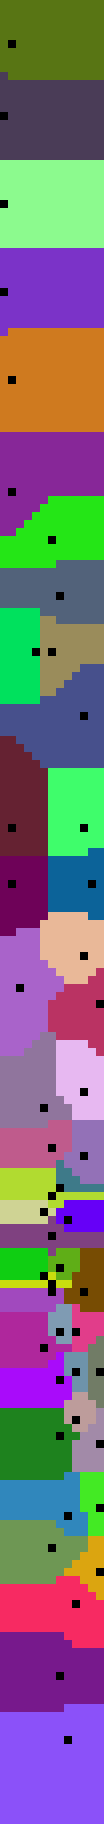

In [157]:
display(c) #jupyter command

In [158]:
c.save('manhattanmcd.png', format=None)

In [159]:
import random
size_of_locations = 20
xs = [random.randint(0,15) for i in range(size_of_locations)]
ys = [random.randint(0,12) for i in range(size_of_locations)]

locations = []
for i in range(size_of_locations):
  locations.append((xs[i], ys[i]))

locations

[(14, 5),
 (15, 8),
 (9, 3),
 (12, 5),
 (4, 0),
 (15, 10),
 (13, 12),
 (3, 7),
 (8, 12),
 (1, 3),
 (12, 1),
 (9, 1),
 (14, 6),
 (0, 12),
 (10, 0),
 (5, 0),
 (4, 10),
 (0, 9),
 (0, 2),
 (11, 7)]

In [160]:
def assign_points(map, prob=0.01):
    locations = []
    for i in range(map.streets):
        for j in range(map.aves):
            if random.random() <= prob:
                locations.append((i, j))
    return locations


In [161]:
delivery_loc = assign_points(map)

In [162]:
#separate locations by McDRegion buckets
def regionize(locations, map):
    regionpoints = {}
    for point in locations:
        i, j = point[0], point[1]
        region = map.grid[i][j].MCDRegion
        if region not in regionpoints:
            regionpoints[region] = []
            regionpoints[region].append(point)
        else:
            regionpoints[region].append(point)
    return regionpoints

In [179]:
loc = regionize(delivery_loc, map)

In [164]:
def calc_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [165]:
pip install landscapes

Note: you may need to restart the kernel to use updated packages.


In [166]:
pip install git+https://github.com/nathanrooy/simulated-annealing

  Cloning https://github.com/nathanrooy/simulated-annealing to c:\users\nahte\appdata\local\temp\pip-req-build-y6ey45b6
  Resolved https://github.com/nathanrooy/simulated-annealing to commit 42eb34e761b76692882a3905ec2be48e19e8133e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://github.com/nathanrooy/simulated-annealing 'C:\Users\nahte\AppData\Local\Temp\pip-req-build-y6ey45b6'


In [167]:
import time
runtimes = {}

## Simulated Annealing Implementation

In [168]:
from simulated_annealing import sa
from landscapes.single_objective import tsp

import pandas as pd
# import osmnx as ox
import networkx as nx
import math
import random

In [169]:
tsp_manhattan = tsp(dist_func=calc_manhattan, close_loop=True).dist

In [170]:
tsp_manhattan(locations)

216

In [ ]:
runtimes[sa.__name__] = 0

In [181]:
len(loc)

25

In [182]:
# cooling_schedule=['linear', 'quadratic', 'exponential', 'logarithmic']
# alpha = None, int(64)
sa_opt_results = []
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    sa_opt_results.append(sa.minimize(tsp_manhattan, locations, opt_mode='combinatorial', cooling_schedule = 'quadratic', step_max=1000000, t_max=1000000, t_min=0))
    te = time.time()
    print(f'func: {sa.__name__} took: {te-ts} sec')
    runtimes[sa.__name__] += te - ts

func: simulated_annealing.sa took: 9.60216212272644 sec
func: simulated_annealing.sa took: 10.483646154403687 sec
func: simulated_annealing.sa took: 9.735581874847412 sec
func: simulated_annealing.sa took: 9.968735933303833 sec
func: simulated_annealing.sa took: 9.417473077774048 sec
func: simulated_annealing.sa took: 10.284338474273682 sec
func: simulated_annealing.sa took: 9.473669052124023 sec
func: simulated_annealing.sa took: 10.578929901123047 sec
func: simulated_annealing.sa took: 9.918881893157959 sec
func: simulated_annealing.sa took: 10.570796012878418 sec
func: simulated_annealing.sa took: 9.778435468673706 sec
func: simulated_annealing.sa took: 10.172922849655151 sec
func: simulated_annealing.sa took: 11.378406286239624 sec
func: simulated_annealing.sa took: 9.506226778030396 sec
func: simulated_annealing.sa took: 9.946057796478271 sec
func: simulated_annealing.sa took: 10.570655584335327 sec
func: simulated_annealing.sa took: 10.03385305404663 sec
func: simulated_annealing

In [172]:
sa_opt_results[0].results()

+------------------------ RESULTS -------------------------+

      opt.mode: combinatorial
cooling sched.: quadratic additive cooling


  initial temp: 1000000
    final temp: 0.000001
     max steps: 1000000
    final step: 1000000

  final energy: 88.000000

+-------------------------- END ---------------------------+


In [183]:
sa_opt_results[0].best_state

[(15, 8),
 (14, 6),
 (14, 5),
 (12, 1),
 (10, 0),
 (5, 0),
 (4, 0),
 (0, 2),
 (1, 3),
 (3, 7),
 (0, 9),
 (0, 12),
 (4, 10),
 (9, 3),
 (9, 1),
 (12, 5),
 (11, 7),
 (8, 12),
 (13, 12),
 (15, 10)]

### State-compression Dynamic Programming to computer the min-cost (shortest path start from the first location but do not return to the initial location)

In [174]:
def dp(n, locations):
	graph = construct_graph(locations, n)
	# for i in range(1, n + 1):
	# 	print(graph[i][1])

	state_size = 1 << n
	f = [
		[float('inf')] * (n + 1)
		for _ in range(state_size)
	]
	f[1][1] = 0
	for state in range(state_size):
		for i in range(2, n + 1):
			if state & (1 << (i - 1)) == 0:
				continue

			prev_state = state ^ (1 << (i - 1))
			for j in range(1, n + 1):
				if prev_state & (1 << (j - 1)) == 0:
					continue

				f[state][i] = min(f[state][i], f[prev_state][j] + graph[j][i])

	return min(f[state_size - 1])


def construct_graph(locations, n):
	graph = {
		i: {j: float('inf') for j in range(1, n + 1)}
		for i in range(1, n + 1)
	}

	for i in range(1, n + 1):
		for j in range(1, n + 1):
			graph[i][j] = calc_manhattan(locations[i - 1],locations[j - 1])
			graph[j][i] = graph[i][j]
	return graph

In [184]:
dp_minCost = []
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    dp_minCost.append(dp(len(loc_list), loc_list))
    te = time.time()
    print('The global min-cost is: ', dp_minCost[-1])
    print(f'func: {dp.__name__} took: {te-ts} sec')
    runtimes[dp.__name__] = te - ts

The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  18
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  16
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  4
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  15
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 sec
The global min-cost is:  18
func: dp took: 0.0 sec
The global min-cost is:  0
func: dp took: 0.0 

## Held-Karp Implementation

In [187]:
import itertools

def construct_dists(locations, n):
	dists = [[0] * n for i in range(n)]

	for i in range(n):
		for j in range(n):
			dists[i][j] = calc_manhattan(locations[i],locations[j])
			# graph[j][i] = graph[i][j]
	return dists

def held_karp(n, locations):

    dists = construct_dists(locations, n)
    # print(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

In [189]:
hk_results = []
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    hk_results.append(held_karp(len(loc_list), loc_list))
    te = time.time()
    print(f'func: {dp.__name__} took: {te-ts} sec')
    runtimes[held_karp.__name__] = te - ts

ValueError: min() arg is an empty sequence

## Runtime Analysis

<BarContainer object of 3 artists>

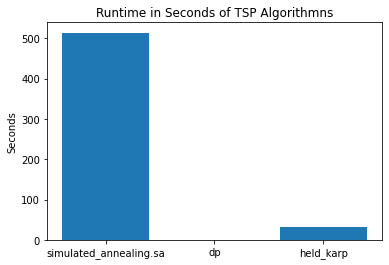

In [190]:
k, v = runtimes.keys(), runtimes.values()
plt.title('Runtime in Seconds of TSP Algorithmns')
plt.ylabel('Seconds')
plt.bar(k, v)